# 3. Potential Evapotranspiration from KNMI data
*R.A. Collenteur, Eawag, 2023*

Data source: KNMI - https://dataplatform.knmi.nl/

In this notebook it is shown how to compute (potential) evapotranspiration from meteorological data using PyEt. Meteorological data is observed by the KNMI at De Bilt in the Netherlands.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyet
pyet.show_versions()

Python version: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
Numpy version: 1.26.2
Pandas version: 2.1.3
Pyet version: 1.2.3b


## 1. Load KNMI Data

We first load the raw meteorological data observed by the KNMI at De Bilt in the Netherlands. This datafile contains a lot of different variables, please see the end of the notebook for an explanation of all the variables. 

In [2]:
data = pd.read_csv("data//example_3//etmgeg_260.txt", skiprows=46, delimiter=",", 
                   skipinitialspace=True, index_col="YYYYMMDD", parse_dates=True).loc["2018",:]
data.head()

,# STN,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,
2018-01-01,260,225,45,50,90,2,10,18,190.0,2.0,...,2.0,75.0,3.0,7.0,84,96,17,73,1,3
2018-01-02,260,216,39,45,80,24,20,1,140.0,24.0,...,19.0,75.0,8.0,7.0,88,96,3,80,8,2
2018-01-03,260,257,82,88,120,11,70,4,290.0,3.0,...,1.0,75.0,4.0,8.0,73,95,1,65,9,1
2018-01-04,260,238,51,56,90,20,30,14,180.0,20.0,...,14.0,80.0,21.0,8.0,82,97,14,67,21,2
2018-01-05,260,225,38,40,60,1,20,17,150.0,16.0,...,15.0,75.0,1.0,6.0,87,96,17,71,3,2


## 2. Estimating potential evapotranspiration

Now that we have the input data, we can estimate potential evapotranspiration with different estimation methods. Here we choose the Penman, Priestley-Taylor, Makkink, and Oudin methods. 

In [3]:
# Preprocess the input data
meteo = pd.DataFrame({"tmean":data.TG/10, "tmax":data.TX/10, "tmin":data.TN/10, 
                      "rh":data.UG, "wind":data.FG/10, "rs":data.Q/100})
tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]
pressure =  data.PG / 100  # to kPa
wind = data.FG / 10  # to m/s
lat = 0.91  # Latitude of the meteorological station
elevation = 4  # meters above sea-level 

# Estimate evapotranspiration with four different methods
pet_penman = pyet.penman(tmean, wind, rs=rs, elevation=4, lat=0.91, tmax=tmax, tmin=tmin, rh=rh)
pet_pt = pyet.priestley_taylor(tmean, rs=rs, elevation=4, lat=0.91, tmax=tmax, tmin=tmin, rh=rh)
pet_makkink = pyet.makkink(tmean, rs, elevation=4, pressure=pressure)
pet_oudin = pyet.oudin(tmean, lat=0.91)

## 3. Plot the results

We plot the cumulative sums to compare the different estimation methods.

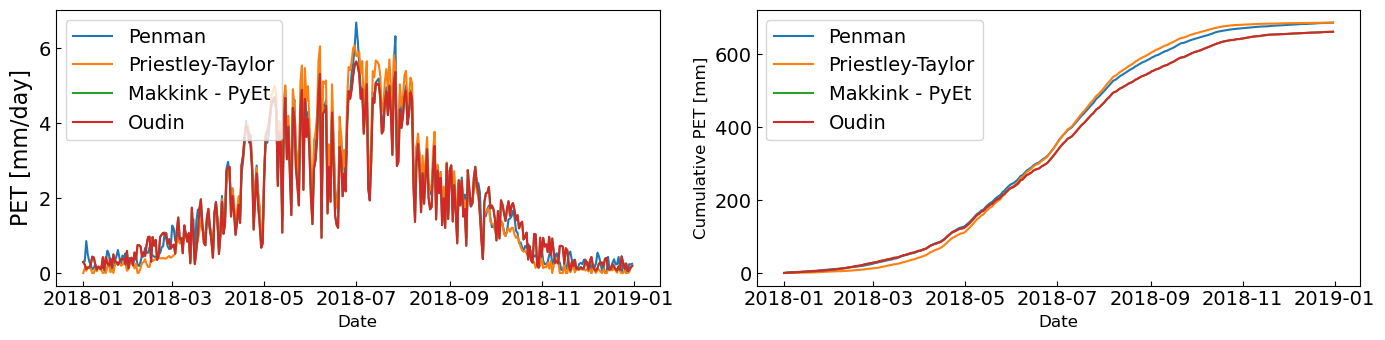

In [4]:
fig, axs = plt.subplots(figsize=(14,3.5), ncols=2)

pet = [pet_penman, pet_pt, pet_makkink, pet_makkink]
names = ["Penman", "Priestley-Taylor", "Makkink - PyEt", "Oudin"]

for df, name in zip(pet, names):
    axs[0].plot(df,label=name)
    axs[1].plot(df.cumsum(),label=name)

axs[0].set_ylabel("PET [mm/day]", fontsize=16)
axs[1].set_ylabel("Cumulative PET [mm]", fontsize=12)

for i in (0,1):
    axs[i].set_xlabel("Date", fontsize=12)
    axs[i].legend(loc=2, fontsize=14)
    axs[i].tick_params("both", direction="in", labelsize=14)
plt.tight_layout()

#plt.savefig("Figure1.png", dpi=300)

## 4. Comparison: pyet Makkink vs KNMI Makkink

The KNMI also provides Makkink potential evapotranspiration data (column EV24). We can now compare the results from Pyet and the KNMI to confirm that these are roughly the same. Pyet also has a method `makkink_knmi` that calculates exactly the same Makkink evaporation as the KNMI but that is only suitable for the Netherlands.

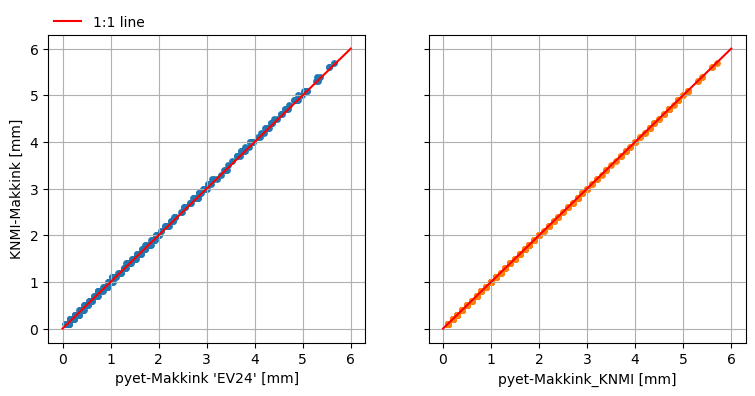

In [5]:
pet_knmi = data.EV24 / 10  # Makkink potential evaporation computen by the KNMI for comparison
pet_makkink_knmi = pyet.makkink_knmi(tmean, rs).round(1) # same as pet_knmi (if rounded up to 1 decimal) but calculated from tmean and rs

# Plot the two series against each other
_, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
ax[0].scatter(pet_makkink, pet_knmi, s=15, color="C0")
ax[0].plot([0,6],[0,6], color="red", label="1:1 line")
ax[0].set_xlabel("pyet-Makkink 'EV24' [mm]")
ax[0].grid()

ax[1].scatter(pet_makkink_knmi, pet_knmi, s=15, color="C1")
ax[1].plot([0,6],[0,6], color="red")
ax[1].set_xlabel("pyet-Makkink_KNMI [mm]")
ax[1].grid()

ax[0].set_ylabel("KNMI-Makkink [mm]")
ax[0].legend(loc=(0,1), frameon=False)


## 5. Estimation of PET - all methods

In [6]:
pet_df = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax=tmax,
                                tmin=tmin, rh=rh)

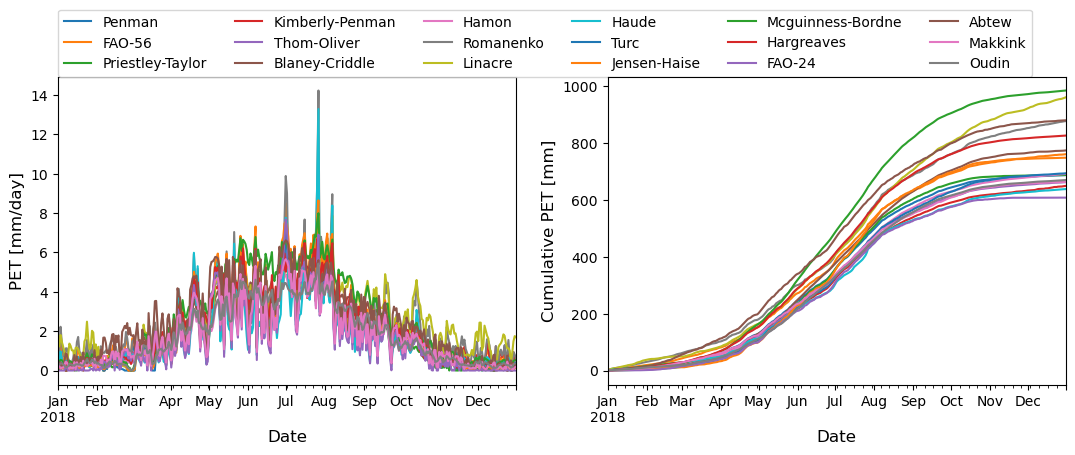

In [7]:
fig, axs = plt.subplots(figsize=(13,4), ncols=2)
pet_df.plot(ax=axs[0])
pet_df.cumsum().plot(ax=axs[1], legend=False)

axs[0].set_ylabel("PET [mm/day]", fontsize=12)
axs[1].set_ylabel("Cumulative PET [mm]", fontsize=12)
axs[0].legend(ncol=6, loc=[0,1.])
for i in (0,1):
    axs[i].set_xlabel("Date", fontsize=12)

In [8]:
#plt.savefig("PET_methods.png", dpi=300)

## References

Column description of the KNMI data

- DDVEC     = Vector mean wind direction in degrees (360=north, 90=east, 180=south, 270=west, 0=calm/variable)
- FHVEC     = Vector mean windspeed (in 0.1 m/s)
- FG        = Daily mean windspeed (in 0.1 m/s) 
- FHX       = Maximum hourly mean windspeed (in 0.1 m/s)
- FHXH      = Hourly division in which FHX was measured
- FHN       = Minimum hourly mean windspeed (in 0.1 m/s)
- FHNH      = Hourly division in which FHN was measured
- FXX       = Maximum wind gust (in 0.1 m/s)
- FXXH      = Hourly division in which FXX was measured
- TG        = Daily mean temperature in (0.1 degrees Celsius)
- TN        = Minimum temperature (in 0.1 degrees Celsius)
- TNH       = Hourly division in which TN was measured
- TX        = Maximum temperature (in 0.1 degrees Celsius)
- TXH       = Hourly division in which TX was measured
- T10N      = Minimum temperature at 10 cm above surface (in 0.1 degrees Celsius)
- T10NH     = 6-hourly division in which T10N was measured; 6=0-6 UT, 12=6-12 UT, 18=12-18 UT, 24=18-24 UT 
- SQ        = Sunshine duration (in 0.1 hour) calculated from global radiation (-1 for <0.05 hour)
- SP        = Percentage of maximum potential sunshine duration
- Q         = Global radiation (in J/cm2)
- DR        = Precipitation duration (in 0.1 hour)
- RH        = Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
- RHX       = Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
- RHXH      = Hourly division in which RHX was measured
- PG        = Daily mean sea level pressure (in 0.1 hPa) calculated from 24 hourly values
- PX        = Maximum hourly sea level pressure (in 0.1 hPa)
- PXH       = Hourly division in which PX was measured
- PN        = Minimum hourly sea level pressure (in 0.1 hPa)
- PNH       = Hourly division in which PN was measured
- VVN       = Minimum visibility; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)
- VVNH      = Hourly division in which VVN was measured
- VVX       = Maximum visibility; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)
- VVXH      = Hourly division in which VVX was measured
- NG        = Mean daily cloud cover (in octants, 9=sky invisible)
- UG        = Daily mean relative atmospheric humidity (in percents)
- UX        = Maximum relative atmospheric humidity (in percents)
- UXH       = Hourly division in which UX was measured
- UN        = Minimum relative atmospheric humidity (in percents)
- UNH       = Hourly division in which UN was measured
- EV24      = Potential evapotranspiration (Makkink) (in 0.1 mm)